<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/YOLOv5_Hyperparameter_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/

In [ ]:
!mkdir ./colab

In [ ]:
%cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


# Install Requirements

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

clear_output()

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


# Get a Dataset

In [ ]:
!mkdir ../datasets

In [ ]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/drive/MyDrive/colab/datasets"

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="hqecDDiHcpNES0AxG9i3")
project = rf.workspace("caitlin-hall").project("shipclassification")
dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/drive/MyDrive/colab/datasets/ShipClassification-3 in yolov5pytorch:: 100%|██████████| 2714/2714 [00:20<00:00, 134.22it/s]


This dataset includes 1351 images of the next ship types:
* Container Ship
* Cruise Ship
* Military Ship
* RORO
* Tanker

Ships are annotated in YOLO v5 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

No image augmentation techniques were applied.

# Hyperparameter Evolution

Hyperparameters in ML control various aspects of training, and finding optimal values for them can be a challenge. Traditional methods like grid searches can quickly become intractable due to
<br>
1) the high dimensional search space,
<br>
2) unknown correlations among the dimensions,
<br>
3) expensive nature of evaluating the fitness at each point.
<br>
These reasons makes GA a suitable candidate for hyperparameter searches.

In [ ]:
!python train.py --epochs 10 \
                 --data '/content/drive/MyDrive/colab/datasets/ShipClassification-3/data.yaml' \
                 --weights yolov5m.pt \
                 --cache \
                 --evolve

# Train the Data

In [ ]:
!python train.py --img 416 \
                 --batch 32 \
                 --epochs 150 \
                 --data '/content/drive/MyDrive/colab/datasets/ShipClassification-3/data.yaml' \
                 --weights yolov5m.pt \
                 --cache \
                 --hyp "/content/drive/MyDrive/colab/yolov5/runs/evolve/exp/hyp_evolve.yaml"

# Evaluate the Model Performance

In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/colab/yolov5/runs/train/

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# create a metrics list
metrics_list = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'metrics/precision', 'metrics/recall']

plt.rcParams["figure.figsize"] = (10,10)

# helper function for inline display of training runs without using TensorBoard
# path_dict - paths to multiple results.csv files
# num - number of evenly spaced numbers over the interval of epochs
#     - changeable to obtain better interpolations of the training runs
def metrics_plotting(path_dict, num):
    for n, metric in enumerate (metrics_list):
        n += 1
        plt.subplot(2, 2, n)
        for path in path_dict:
            data = pd.read_csv(path_dict[path], sep=',', header=0, skipinitialspace=True)

            # rename the metrics columns with the keys in path_dict
            data.rename(columns={metric : path}, inplace=True)

            # compute the coefficients of interpolating B-spline and its values     
            spline = make_interp_spline(data['epoch'], data[path])
            epochs = np.linspace(0, len(data), num)                
            spline_values = spline(epochs)

            # change the end spline value to have matching with the real one on your plot
            spline_values[-1]=data[path].to_numpy()[-1]

            # plot the training and spline curve
            plt.plot('epoch', path, data=data, linestyle=':', linewidth=1, alpha=0.8)
            plt.plot(epochs, spline_values, linewidth=2, label=path)

        plt.title(metric)
        plt.xlabel('epoch')
        plt.legend()
    plt.show()

In [ ]:
# helper function for table display of metrics values for training runs in path dictionary
def metrics_table(path_dict):
    for n, path in enumerate(path_dict):
        train_data = pd.read_csv(path_dict[path], sep=',', header=0, skipinitialspace=True)
        
        # rename the end row index with the path key in the path dictionary
        train_data.rename(index={len(train_data)-1 : path}, inplace=True)

        # locate the metrics columns and extract the values for the last epoch
        train_metrics = train_data.loc[:, metrics_list]
        comparison_data = train_metrics.tail(1)

        # for multiple runs, concatenate the metrics values
        if n == 0:
            comparsion_table = pd.concat([comparison_data])
        else:
            comparsion_table = pd.concat([comparsion_table, comparison_data])   

    return comparsion_table

In [ ]:
path_dict = {'The best weights': '/content/drive/MyDrive/colab/yolov5/runs/train/exp/results.csv',
            }

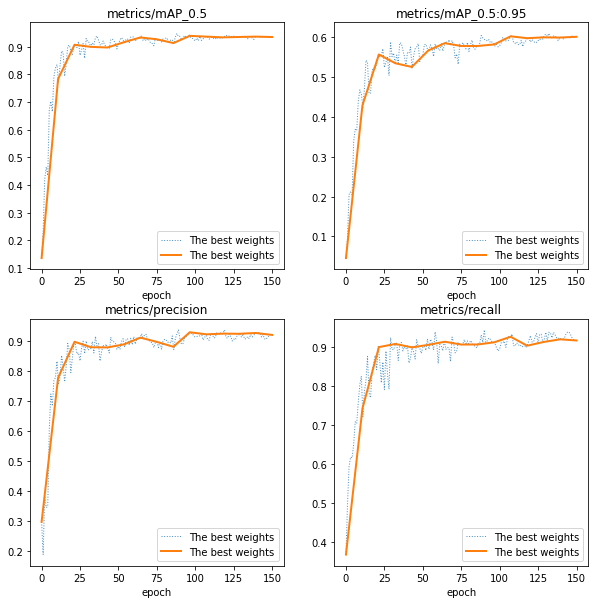

,metrics/mAP_0.5,metrics/mAP_0.5:0.95,metrics/precision,metrics/recall
The best weights,0.93513,0.60132,0.9196,0.91715


In [ ]:
metrics_plotting(path_dict=path_dict, num=15)
metrics_table(path_dict=path_dict)

# Run Inference With Trained Weights

In [ ]:
!mkdir /content/drive/MyDrive/colab/detections

In [ ]:
!python detect.py --weights /content/drive/MyDrive/colab/yolov5/runs/train/exp/weights/best.pt \
                  --img 416 \
                  --conf 0.5 \
                  --source /content/drive/MyDrive/colab/datasets/ShipClassification-3/test/images \
                  --project /content/drive/MyDrive/colab/detections

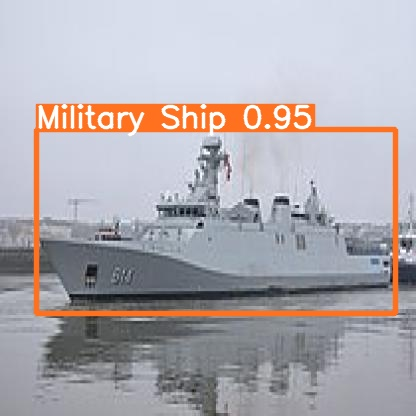

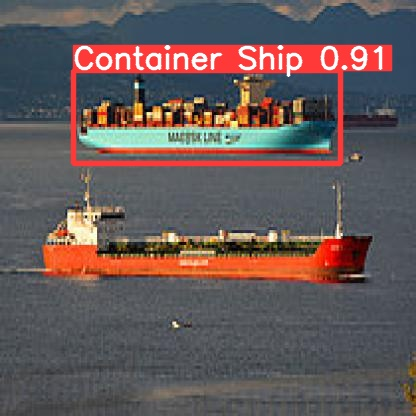

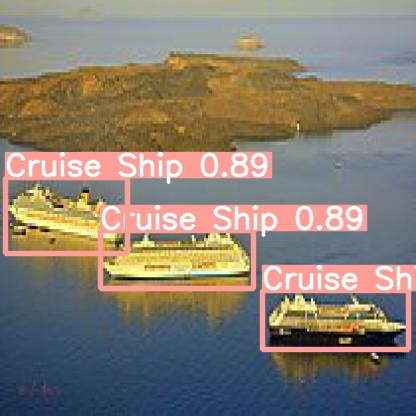

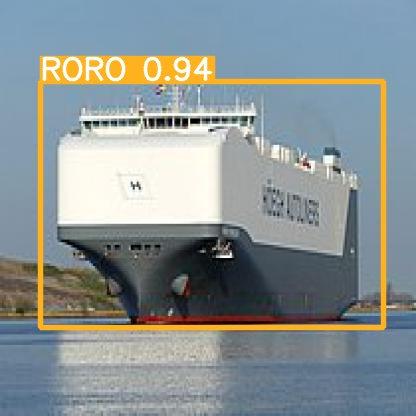

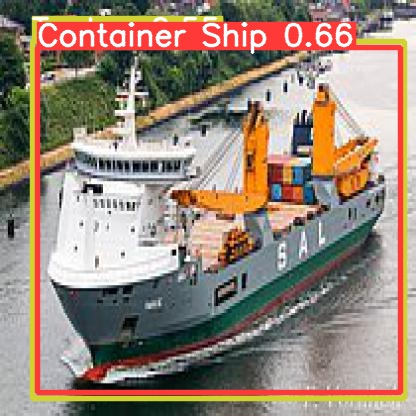

In [ ]:
from IPython.display import Image, display

image_path = {
    'image1' : '/content/drive/MyDrive/colab/detections/exp/2837905_jpg.rf.304841f7b6ab560e4fd4c74d269824a3.jpg',
    'image2' : '/content/drive/MyDrive/colab/detections/exp/2798434_jpg.rf.ded6e86c9804ed672e65c39c03c23041.jpg',
    'image3' : '/content/drive/MyDrive/colab/detections/exp/2068048_jpg.rf.69e631ccf8f59d46450dcea189605feb.jpg',
    'image4' : '/content/drive/MyDrive/colab/detections/exp/2842785_jpg.rf.5eaa3cd6d49cd46274dcfcec9ccfea17.jpg',
    'image5' : '/content/drive/MyDrive/colab/detections/exp/2868074_jpg.rf.25b21360b7cf42e07c353e65ce0f24bb.jpg'
    }

for image in image_path:
    display(Image(filename=image_path[image], width=300))